## Import libraries
Import libraries to perform one hot coding and rescaling of features

In [3]:
## Import librariries
import sys, os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load
import pickle
from typing import List, Tuple
from datetime import datetime
from dateutil import parser

## Import raw features
Import the raw feature file and inspect it.

In [4]:
# Read the raw feature CSV file into a pandas DataFrame
raw_feature_df = pd.read_csv("/Users/adityaponnada/Downloads/time_study_data/raw_features_v1.csv")
print(f"Raw feature DataFrame shape: {raw_feature_df.shape}")
raw_feature_df.head()

Raw feature DataFrame shape: (108075, 20)


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_11841/4070788336.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_feature_df = pd.read_csv("/Users/adityaponnada/Downloads/time_study_data/raw_features_v1.csv")


,participant_id,prompt_time_converted,outcome,is_weekend,time_of_day,in_battery_saver_mode,charging_status,location_category,screen_on,dist_from_home,is_phone_locked,last_phone_usage,wake_day_part,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,days_in_study,completion_24h,completion_since_wake,completion_since_start
0,certifiedembargobartender@timestudy_com,2021-10-23 07:46:02,1,1,Early Morning,0.0,0.0,Transit,1,936.101448,0.0,0.0,0.0,838.966667,1.033333,8.138573,176,0.0,0.0,0.0
1,certifiedembargobartender@timestudy_com,2021-10-23 07:54:01,1,1,Early Morning,NaN,NaN,Transit,1,936.101448,0.0,0.0,0.0,830.983333,9.016667,0.280337,176,1.0,1.0,1.0
2,certifiedembargobartender@timestudy_com,2021-10-23 08:24:00,0,1,Morning,0.0,1.0,Other,0,NaN,1.0,18.1,0.0,801.000000,39.000000,0.000000,176,1.0,1.0,1.0
3,certifiedembargobartender@timestudy_com,2021-10-23 08:32:00,1,1,Morning,0.0,1.0,Transit,1,936.101448,0.0,0.0,0.0,793.000000,47.000000,0.000000,176,1.0,1.0,1.0
4,certifiedembargobartender@timestudy_com,2021-10-23 08:44:04,1,1,Morning,NaN,NaN,Transit,0,936.231251,1.0,9.0,0.0,780.933333,59.066667,160.934583,176,1.0,1.0,1.0


## Explore missing data
For all the features, we will get the % of missing data in them.

In [5]:
def missing_value_table(df):
    skip_cols = ['participant_id', 'prompt_time_converted', 'outcome']
    cols = [col for col in df.columns if col.lower() not in skip_cols]
    missing_percent = df[cols].isnull().mean() * 100
    # Also count empty strings as missing
    empty_percent = (df[cols] == '').mean() * 100
    total_missing_percent = missing_percent + empty_percent
    result = pd.DataFrame({
        'missing_%': total_missing_percent.round(2)
    }).sort_values('missing_%', ascending=False)
    return result
    
# Display missing value table
missing_value_table(raw_feature_df)

,missing_%
in_battery_saver_mode,52.19
charging_status,52.19
dist_from_home,13.88
last_phone_usage,13.80
is_phone_locked,13.80
mims_5min,4.02
wake_day_part,0.04
closeness_to_sleep_time,0.04
closeness_to_wake_time,0.04
completion_since_wake,0.00


In [6]:
def missing_data_by_participant(df):
    skip_cols = ['prompt_time_converted', 'outcome']
    cols = [col for col in df.columns if col.lower() not in skip_cols and col.lower() != 'participant_id']
    # Create a boolean DataFrame for missing values (NaN or empty string)
    missing_bool = df[cols].isnull() | (df[cols] == '')
    # Group by participant_id and calculate % missing for each column
    missing_percent = missing_bool.groupby(df['participant_id']).mean() * 100
    missing_percent = missing_percent.round(2)
    # Reset index to have participant_id as a column
    missing_percent = missing_percent.reset_index()
    return missing_percent

# Print % missing data for each participant and variable
missing_data_by_participant(raw_feature_df)

,participant_id,is_weekend,time_of_day,in_battery_saver_mode,charging_status,location_category,screen_on,dist_from_home,is_phone_locked,last_phone_usage,wake_day_part,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,days_in_study,completion_24h,completion_since_wake,completion_since_start
0,certifiedembargobartender@timestudy_com,0.0,0.0,53.81,53.81,0.0,0.0,29.09,6.98,6.98,0.00,0.00,0.00,4.74,0.0,0.0,0.0,0.0
1,chewingslouchingfailing@timestudy_com,0.0,0.0,52.62,52.62,0.0,0.0,14.44,100.00,100.00,0.00,0.00,0.00,2.99,0.0,0.0,0.0,0.0
2,enjoyergoofinessgrudge@timestudy_com,0.0,0.0,51.62,51.62,0.0,0.0,13.26,0.89,0.89,0.46,0.46,0.46,3.31,0.0,0.0,0.0,0.0
3,erasuresafeguardravishing@timestudy_com,0.0,0.0,51.58,51.58,0.0,0.0,18.20,0.38,0.38,0.00,0.00,0.00,2.38,0.0,0.0,0.0,0.0
4,neutergoldfishsworn@timestudy_com,0.0,0.0,52.61,52.61,0.0,0.0,7.96,8.20,8.20,0.00,0.00,0.00,5.98,0.0,0.0,0.0,0.0
5,persevereriseswoop@timestudy_com,0.0,0.0,51.47,51.47,0.0,0.0,2.56,0.00,0.00,0.00,0.00,0.00,2.26,0.0,0.0,0.0,0.0
6,pretendedconstrainfraying@timestudy_com,0.0,0.0,52.09,52.09,0.0,0.0,10.96,0.00,0.00,0.00,0.00,0.00,3.99,0.0,0.0,0.0,0.0
7,remoldexcludingaffair@timestudy_com,0.0,0.0,51.81,51.81,0.0,0.0,8.12,0.03,0.03,0.00,0.00,0.00,8.59,0.0,0.0,0.0,0.0
8,slapstickporcupineslacks@timestudy_com,0.0,0.0,52.39,52.39,0.0,0.0,12.37,0.00,0.00,0.00,0.00,0.00,2.53,0.0,0.0,0.0,0.0
9,subtitlegrievousbazooka@timestudy_com,0.0,0.0,51.60,51.60,0.0,0.0,21.54,0.00,0.00,0.00,0.00,0.00,5.11,0.0,0.0,0.0,0.0


## one-hot encoding
Convert the categorical variables into one-hot dummy codes

In [8]:
def one_hot_encode_features(df, columns):
    """
    One-hot encode specified categorical columns in the DataFrame.
    Returns a new DataFrame with one-hot encoded columns as 0/1 integers and original columns dropped.
    """
    df_encoded = df.copy()
    df_encoded = pd.get_dummies(df_encoded, columns=columns, prefix=columns, drop_first=False)
    # Ensure all new one-hot columns are int (0/1)
    for col in df_encoded.columns:
        if any(col.startswith(f'{c}_') for c in columns):
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded

# Example usage:
categorical_vars = ['time_of_day', 'location_category', 'wake_day_part']
raw_feature_df_encoded = one_hot_encode_features(raw_feature_df, categorical_vars)
raw_feature_df_encoded.head()

,participant_id,prompt_time_converted,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,2021-10-23 07:46:02,1,1,0.0,0.0,1,936.101448,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,2021-10-23 07:54:01,1,1,NaN,NaN,1,936.101448,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,2021-10-23 08:24:00,0,1,0.0,1.0,0,NaN,1.0,18.1,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,2021-10-23 08:32:00,1,1,0.0,1.0,1,936.101448,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,2021-10-23 08:44:04,1,1,NaN,NaN,0,936.231251,1.0,9.0,...,0,0,0,0,1,0,1,0,0,0


In [10]:
## List the column names in the DataFrame
def list_column_names(df: pd.DataFrame) -> List[str]:
    """
    List all column names in the DataFrame.
    """
    return df.columns.tolist()

## Use the function to get column names
column_names = list_column_names(raw_feature_df_encoded)
print("Column names in the DataFrame:")
print(column_names)

Column names in the DataFrame:
['participant_id', 'prompt_time_converted', 'outcome', 'is_weekend', 'in_battery_saver_mode', 'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'days_in_study', 'completion_24h', 'completion_since_wake', 'completion_since_start', 'time_of_day_Afternoon', 'time_of_day_Early Morning', 'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning', 'time_of_day_Night', 'location_category_Home', 'location_category_Other', 'location_category_School', 'location_category_Transit', 'location_category_Work', 'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0', 'wake_day_part_3.0']


## Normalize features

In [11]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_by_participant(df, columns, group_col='participant_id'):
    """
    Apply min-max scaling (0-1) to specified columns, grouped by participant_id.
    Returns a new DataFrame with scaled columns (original columns replaced).
    """
    df_scaled = df.copy()
    scaler = MinMaxScaler()
    # Apply scaling for each participant
    for pid, group in df.groupby(group_col):
        idx = group.index
        scaled_values = scaler.fit_transform(group[columns])
        df_scaled.loc[idx, columns] = scaled_values
    return df_scaled

# Example usage:
scale_columns = ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min']
raw_feature_df_scaled = min_max_scale_by_participant(raw_feature_df_encoded, scale_columns)
raw_feature_df_scaled[scale_columns + ['participant_id']].head()

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/.venv/lib/python3.13/site-packages/sklearn/utils/_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/.venv/lib/python3.13/site-packages/sklearn/utils/_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


,dist_from_home,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,participant_id
0,0.995567,0.000000,0.891772,0.053885,0.011525,certifiedembargobartender@timestudy_com
1,0.995567,0.000000,0.883542,0.062158,0.000397,certifiedembargobartender@timestudy_com
2,NaN,0.301667,0.852631,0.093228,0.000000,certifiedembargobartender@timestudy_com
3,0.995567,0.000000,0.844384,0.101518,0.000000,certifiedembargobartender@timestudy_com
4,0.995705,0.150000,0.831944,0.114022,0.227901,certifiedembargobartender@timestudy_com


In [15]:
raw_feature_df_scaled.head(5)

,participant_id,prompt_time_converted,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,2021-10-23 07:46:02,1,1,0.0,0.0,1,0.995567,0.0,0.000000,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,2021-10-23 07:54:01,1,1,NaN,NaN,1,0.995567,0.0,0.000000,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,2021-10-23 08:24:00,0,1,0.0,1.0,0,NaN,1.0,0.301667,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,2021-10-23 08:32:00,1,1,0.0,1.0,1,0.995567,0.0,0.000000,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,2021-10-23 08:44:04,1,1,NaN,NaN,0,0.995705,1.0,0.150000,...,0,0,0,0,1,0,1,0,0,0


## Normalize days in study sequence data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_days_in_study_inplace(df, group_col='participant_id', scale_col='days_in_study'):
    """
    Apply min-max scaling (0-1) to 'days_in_study', grouped by participant_id, updating the column in-place.
    """
    scaler = MinMaxScaler()
    for pid, group in df.groupby(group_col):
        idx = group.index
        scaled_values = scaler.fit_transform(group[[scale_col]])
        df.loc[idx, scale_col] = scaled_values.flatten()

min_max_scale_days_in_study_inplace(raw_feature_df_scaled)
raw_feature_df_scaled[["participant_id", "days_in_study"]].head()

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_11841/2872826386.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.50867052 0.50867052 0.50867052 ... 0.47687861 0.47687861 0.47687861]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, scale_col] = scaled_values.flatten()


,participant_id,days_in_study
0,certifiedembargobartender@timestudy_com,0.508671
1,certifiedembargobartender@timestudy_com,0.508671
2,certifiedembargobartender@timestudy_com,0.508671
3,certifiedembargobartender@timestudy_com,0.508671
4,certifiedembargobartender@timestudy_com,0.508671


In [17]:
## List all column names in raw_feature_df_scaled
def list_column_names(df: pd.DataFrame) -> List[str]:
    """
    List all column names in the DataFrame.
    """
    return df.columns.tolist()
# Example usage:
column_names_scaled = list_column_names(raw_feature_df_scaled)
print("Column names in the scaled DataFrame:")
print(column_names_scaled)

Column names in the scaled DataFrame:
['participant_id', 'prompt_time_converted', 'outcome', 'is_weekend', 'in_battery_saver_mode', 'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'days_in_study', 'completion_24h', 'completion_since_wake', 'completion_since_start', 'time_of_day_Afternoon', 'time_of_day_Early Morning', 'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning', 'time_of_day_Night', 'location_category_Home', 'location_category_Other', 'location_category_School', 'location_category_Transit', 'location_category_Work', 'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0', 'wake_day_part_3.0']


## Clean up the data and explore

In [18]:
# Remove the 'prompt_time_converted' column from the DataFrame if it exists
if 'prompt_time_converted' in raw_feature_df_scaled.columns:
    raw_feature_df_scaled = raw_feature_df_scaled.drop(columns=['prompt_time_converted'])
    print("'prompt_time_converted' column removed.")
else:
    print("'prompt_time_converted' column not found in DataFrame.")

'prompt_time_converted' column removed.


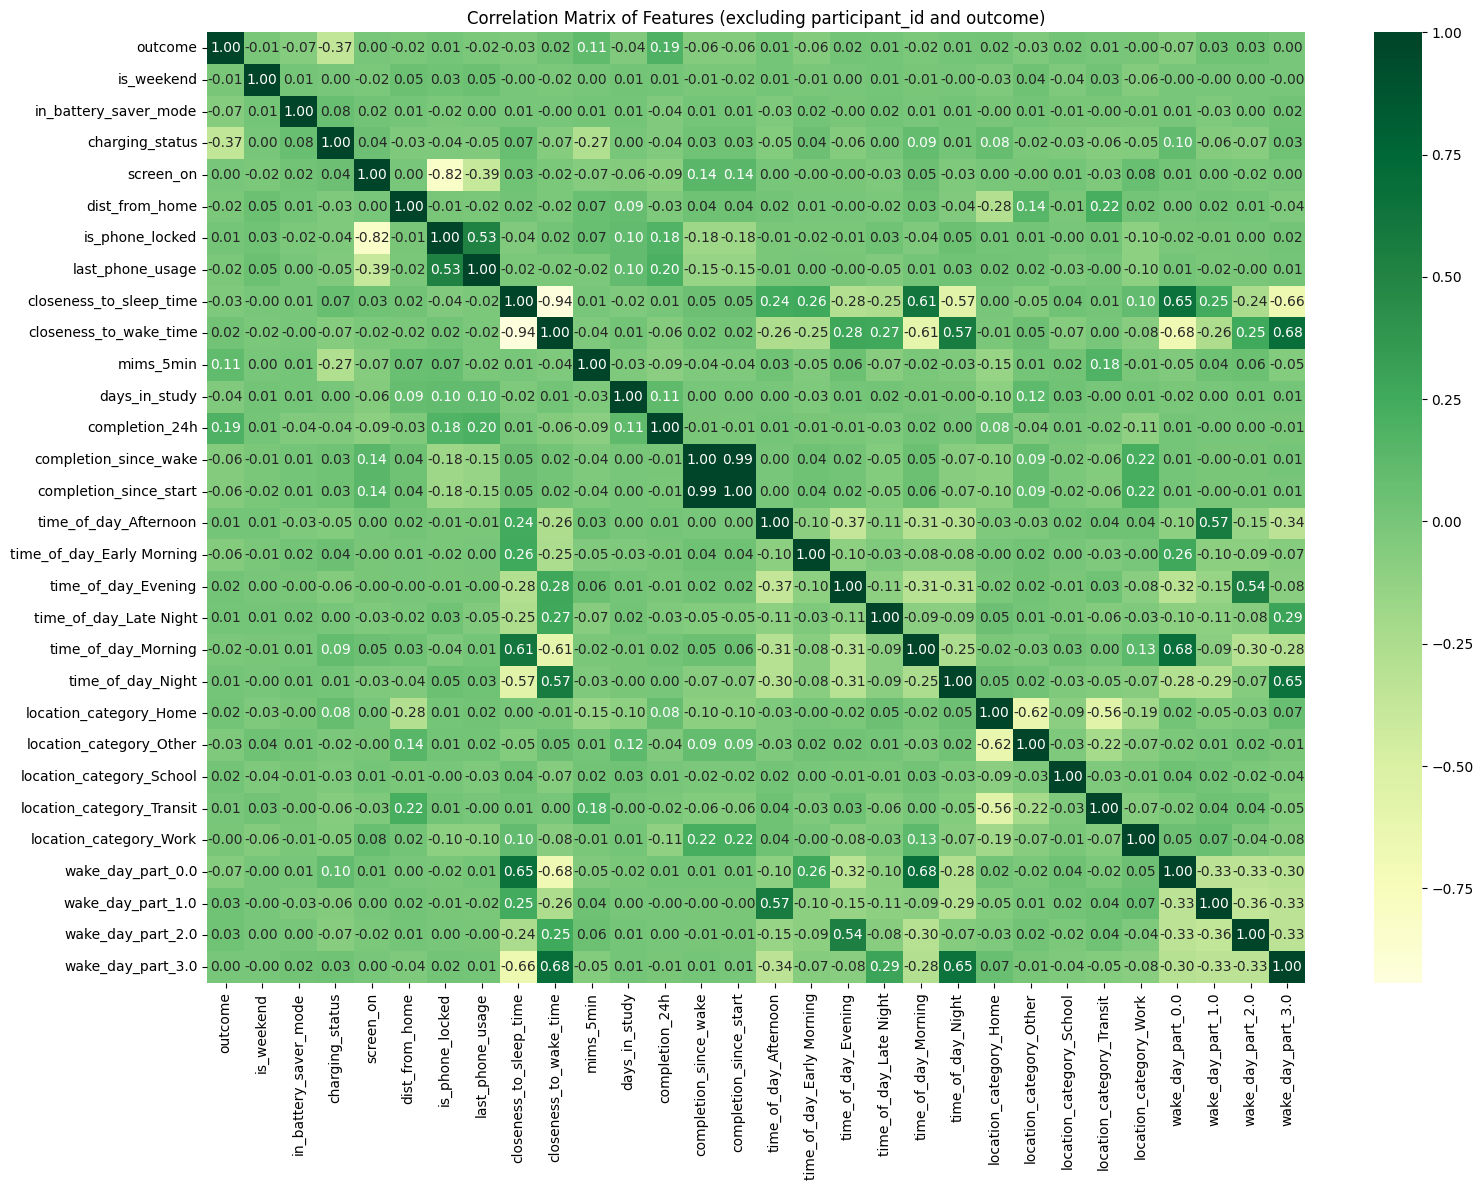

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix of all variables except 'participant_id' and 'outcome'
corr_df = raw_feature_df_scaled.drop(columns=['participant_id'], errors='ignore')
corr_matrix = corr_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGn', center=0)
plt.title('Correlation Matrix of Features (excluding participant_id and outcome)')
plt.tight_layout()
plt.show()

## Export file

In [24]:
## Write the file to the main data directory
output_file_path = "/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv"
raw_feature_df_scaled.to_csv(output_file_path, index=False)
print(f"Processed features saved to {output_file_path}")

Processed features saved to /Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv
